In [ ]:
# Import standard-library modules.
import json, os                 # 'json' reads/writes JSON; 'os' is imported but not used below.

# Import third-party libraries.
import networkx as nx           # NetworkX is used to build and save the graph.
import matplotlib.pyplot as plt # Matplotlib is imported here but not used in this script.

# ---------- config ----------
INPUT_JSON = "output_similarity_2324F.json"   # Path to the input JSON file with course similarity data.
OUTPUT_PREFIX = "courses_similarity_2324"      # Prefix used for the output filenames we will write.
KEEP_TOP_K = None                              # If set to an integer (e.g., 20), keep only the top-K neighbors per node.
MIN_SIM = None                                 # If set to a float (e.g., 0.60), drop pairs with similarity below this.

def canon_node_id(codes):
    """
    Given a list like ['EDST-200','AMST-200','SOCI-200'],
    return a stable, canonical node ID string.

    Why do this?
    - We want the same combination of codes to map to the same node,
      regardless of their order in the list. This allows us to parse cross-listed courses.
    """
    # Build a cleaned list:
    # - str(c): ensure each element is a string
    # - .strip(): remove surrounding whitespace
    # - if c and str(c).strip(): skip Nones/empties
    cleaned = [str(c).strip() for c in codes if c and str(c).strip()]
    # Sort for order-independence (['B','A'] -> ['A','B'])
    cleaned_sorted = sorted(cleaned)
    # Join with '|' to create a single canonical ID, e.g., 'AMST-200|EDST-200|SOCI-200'
    return "|".join(cleaned_sorted)

# ---------- load ----------
# Open the input JSON file for reading as text ('r').
with open(INPUT_JSON, "r") as f:
    # Parse the entire JSON file into a Python object.
    # We expect a list of dicts, each roughly like:
    # {
    #   "course_codes": ["EDST-200","AMST-200"],
    #   "compared_courses": [
    #       {"course_codes": ["SOCI-200"], "similarity_score": 0.83},
    #       ...
    #   ]
    # }
    data = json.load(f)

# ---------- gather similarities ----------
# We will aggregate edges in a dictionary before building the graph.
# Key: a tuple (u, v) with u < v (sorted order) so each undirected edge is unique.
# Value: the maximum similarity observed between u and v across all entries.
edges_acc = {}

# We'll also track the original list of course codes for each node in a dictionary,
# so we can save them as a readable attribute on the node.
# Key: node_id (canonical string), Value: a tuple of sorted course codes.
node_codes = {}

# Iterate over each entry (row) in the input data.
for entry in data:
    # Extract the "source" course code list; if missing, use [].
    src_codes = entry.get("course_codes", [])
    # If the source codes are empty, skip this entry entirely.
    if not src_codes:
        continue

    # Create a canonical node ID for the source node.
    u = canon_node_id(src_codes)

    # Ensure the node is recorded in node_codes.
    # setdefault inserts the key with the provided default if absent; otherwise it leaves it unchanged.
    node_codes.setdefault(u, tuple(sorted(src_codes)))

    # Extract the list of comparisons from this source entry.
    # The "or []" ensures that if the value is None, we still get an empty list.
    compared = entry.get("compared_courses", []) or []

    # We'll optionally keep only top-K similar neighbors per *source node*.
    # To do that, we first gather all (neighbor, similarity) pairs locally.
    pairs = []

    # Loop over all compared items for this source node.
    for comp in compared:
        # Destination (neighbor) course codes for this comparison.
        dst_codes = comp.get("course_codes", [])
        # Skip if missing or empty.
        if not dst_codes:
            continue

        # Canonical node ID for the neighbor.
        v = canon_node_id(dst_codes)
        # Make sure the neighbor node is recorded with its readable codes.
        node_codes.setdefault(v, tuple(sorted(dst_codes)))

        # Extract similarity score; could be absent -> None.
        sim = comp.get("similarity_score", None)
        # If similarity is missing, skip this pair.
        if sim is None:
            continue

        # If a minimum similarity threshold is set, drop weak pairs.
        if MIN_SIM is not None and sim < MIN_SIM:
            continue

        # Store the neighbor and similarity (cast to float for safety).
        pairs.append((v, float(sim)))

    # If we are keeping only the top-K neighbors (by similarity) for this source node:
    if KEEP_TOP_K is not None and len(pairs) > KEEP_TOP_K:
        # Sort pairs descending by similarity: highest similarity first.
        pairs.sort(key=lambda t: t[1], reverse=True)
        # Truncate to the first KEEP_TOP_K pairs.
        pairs = pairs[:KEEP_TOP_K]

    # Add this source node's pairs into the global accumulator.
    # We treat the graph as undirected, so we sort (u, v) to have a unique key.
    for v, sim in pairs:
        # Avoid self-loops (u -> u).
        if u == v:
            continue
        # Sort the two node IDs so (u, v) and (v, u) become the same edge key.
        a, b = sorted((u, v))

        # If we already saw an edge for (a, b), keep the maximum similarity encountered.
        # (Later we'll convert similarity to a "distance" weight via 1 - similarity,
        #  and max similarity -> min distance.)
        prev = edges_acc.get((a, b))
        edges_acc[(a, b)] = sim if prev is None else max(prev, sim)

# ---------- build graph ----------
# Create an empty undirected NetworkX graph.
G = nx.Graph()

# Add all nodes first. Each node gets a 'codes' attribute that stores the
# human-readable course code list joined by '|'.
for node, codes in node_codes.items():
    G.add_node(node, codes="|".join(codes))

# Add edges with attributes:
# - 'similarity': the similarity score we kept
# - 'weight': a distance for many algorithms = 1 - similarity
for (u, v), sim in edges_acc.items():
    G.add_edge(u, v, similarity=sim, weight=(1.0 - sim))  # weight is often treated as distance.

# Print a quick summary of the graph size to the console.
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# ---------- save ----------
# Build output filenames from the prefix.
gexf_path = f"{OUTPUT_PREFIX}.gexf"       # GEXF is a format Gephi can read.
graphml_path = f"{OUTPUT_PREFIX}.graphml" # GraphML is an XML-based graph format.

# Write the graph to GEXF.
nx.write_gexf(G, gexf_path)

# Write the graph to GraphML. GraphML is stricter about attribute types;
# we've stored only simple strings/numbers, so this should be fine.
nx.write_graphml(G, graphml_path)

# Let the user know where files were saved.
print("Saved:")
print(" -", gexf_path)
print(" -", graphml_path)

Graph: 465 nodes, 107880 edges
Saved:
 - courses_similarity_2324.gexf
 - courses_similarity_2324.graphml


In [16]:
## sanity check

# --- set these ---
INPUT_JSON   = "output_similarity_2324F.json"   # Path to the original JSON file with your raw similarity data.
GRAPH_PATH   = None  # If you already saved the graph to disk (e.g., .gexf or .graphml), put that path here to reload it.
KEEP_TOP_K   = None  # If you originally filtered to top-K most similar neighbors per node, set that number here; else None.
MIN_SIM      = None  # If you originally filtered out similarities below a threshold, set that here; else None.
TOL          = 1e-9  # Tolerance for floating-point comparisons when checking weights (handles tiny rounding errors).

def canon_node_id(codes):
    """
    Make a consistent (canonical) ID for a node given a list of course codes.

    For example:
      ['SOCI-200', 'EDST-200', 'AMST-200'] → "AMST-200|EDST-200|SOCI-200"

    Steps:
      - Remove empty/None entries
      - Convert all codes to strings and strip whitespace
      - Sort alphabetically so order doesn't matter
      - Join them with "|" into a single string ID
    """
    return "|".join(sorted([str(c).strip() for c in codes if c and str(c).strip()]))

# Load JSON
with open(INPUT_JSON, "r") as f:      # Open the input JSON file for reading as text
    data = json.load(f)               # Parse JSON into a Python object (should be a list of dicts)

# Get G (either from your live notebook or re-load)
if GRAPH_PATH:                        # If GRAPH_PATH is provided (not None), load the graph from disk.
    if GRAPH_PATH.endswith(".gexf"):  # If file ends with .gexf → load as GEXF format
        G = nx.read_gexf(GRAPH_PATH)
    else:                             # Otherwise assume GraphML format
        G = nx.read_graphml(GRAPH_PATH)
# else: assumes you already have G in memory from earlier

# ---------- Rebuild expected node set ----------
expected_nodes = set()  # Create an empty set to store all unique node IDs expected from the JSON
for entry in data:
    u = canon_node_id(entry.get("course_codes", []))  # Canonical ID for the "source" course
    if u:
        expected_nodes.add(u)                         # Add to set of expected nodes
    for comp in entry.get("compared_courses", []) or []:  # Loop over all comparisons for this source
        v = canon_node_id(comp.get("course_codes", []))   # Canonical ID for "target" course
        if v:
            expected_nodes.add(v)                      # Add target node to set too

print(f"JSON unique nodes: {len(expected_nodes)}")  # How many unique nodes we found from JSON
print(f"Graph nodes:       {G.number_of_nodes()}")   # How many nodes are actually in the graph

# Compare node sets
extra_in_graph  = set(G.nodes()) - expected_nodes     # Nodes in graph but not in JSON
missing_in_graph = expected_nodes - set(G.nodes())    # Nodes in JSON but missing from graph

print(f"Nodes missing in graph: {len(missing_in_graph)}")
print(f"Nodes present only in graph: {len(extra_in_graph)}")
if missing_in_graph:
    print("  e.g.", list(sorted(missing_in_graph))[:5])
if extra_in_graph:
    print("  e.g.", list(sorted(extra_in_graph))[:5])

# ---------- Rebuild expected edge set ----------
# Apply the SAME rules you used: undirected, de-duplicate by max similarity,
# optional MIN_SIM and per-node KEEP_TOP_K.

# First collect per-source neighbor lists if you need top-k
per_source = {}  # Dictionary: source_node -> list of (neighbor, similarity) pairs
for entry in data:
    u = canon_node_id(entry.get("course_codes", []))
    if not u: 
        continue
    pairs = []
    for comp in entry.get("compared_courses", []) or []:
        v = canon_node_id(comp.get("course_codes", []))
        sim = comp.get("similarity_score", None)
        if not v or sim is None:
            continue
        sim = float(sim)
        if MIN_SIM is not None and sim < MIN_SIM:  # Drop if below threshold
            continue
        if u == v:  # Skip self-loops
            continue
        pairs.append((v, sim))
    # Keep only top-K most similar if required
    if KEEP_TOP_K is not None and len(pairs) > KEEP_TOP_K:
        pairs.sort(key=lambda t: t[1], reverse=True)  # Sort by similarity descending
        pairs = pairs[:KEEP_TOP_K]
    per_source.setdefault(u, []).extend(pairs)

# Merge to undirected by keeping MAX similarity (=> min distance)
expected_edges = {}  # Key: (a,b) sorted tuple; Value: max similarity
for u, pairs in per_source.items():
    for v, sim in pairs:
        a, b = sorted((u, v))  # Sort to enforce undirected uniqueness
        prev = expected_edges.get((a,b))
        expected_edges[(a,b)] = sim if prev is None else max(prev, sim)

print(f"Expected undirected edges: {len(expected_edges)}")
print(f"Graph edges:               {G.number_of_edges()}")

graph_edge_set = set(tuple(sorted(e)) for e in G.edges())  # All edges from the graph
expected_edge_set = set(expected_edges.keys())             # All expected edges from JSON

missing_edges = expected_edge_set - graph_edge_set         # Edges in JSON but not in graph
extra_edges   = graph_edge_set - expected_edge_set         # Edges in graph but not in JSON

print(f"Edges missing in graph: {len(missing_edges)}")
print(f"Edges present only in graph: {len(extra_edges)}")
if missing_edges:
    print("  e.g.", list(sorted(missing_edges))[:5])
if extra_edges:
    print("  e.g.", list(sorted(extra_edges))[:5])

# ---------- Check weights (distance = 1 - similarity) ----------
bad_weights = []
for (a,b), exp_sim in expected_edges.items():
    if not G.has_edge(a,b):
        continue
    d = G[a][b]  # This is the edge attribute dictionary
    # Try to get the stored similarity
    g_sim = d.get("similarity")
    if g_sim is None and "weight" in d:  # If similarity missing, reconstruct from weight
        g_sim = 1.0 - float(d["weight"])
    if g_sim is None:
        bad_weights.append((a,b,"missing weight/similarity"))
        continue
    # Compare expected similarity vs actual; flag if difference > tolerance
    if abs(float(g_sim) - float(exp_sim)) > TOL:
        bad_weights.append((a,b,exp_sim,g_sim))

print(f"Edges with mismatched similarity/weight: {len(bad_weights)}")
if bad_weights[:5]:
    print("  e.g.", bad_weights[:5])

# ---------- Quick per-node spot checks ----------
def show_neighbors(node, k=10):
    """Print top-k nearest neighbors by similarity (descending) from the graph."""
    if node not in G:
        print("Node not in graph")
        return
    nbrs = []
    for v in G.neighbors(node):   # Iterate over all connected neighbors
        d = G[node][v]            # Get edge attributes
        sim = d.get("similarity") # Try to read similarity directly
        if sim is None and "weight" in d:
            sim = 1.0 - float(d["weight"])  # Convert distance to similarity if needed
        nbrs.append((v, float(sim)))
    nbrs.sort(key=lambda x: x[1], reverse=True)  # Sort neighbors by similarity descending
    for v, s in nbrs[:k]:  # Show only the top k
        print(f"{node} -- {v} : similarity={s:.6f}  distance={1.0 - s:.6f}")

# Example usage after loading the graph:
# show_neighbors("AMST-221")                       # if you used single-code nodes
# show_neighbors("AMST-200|EDST-200|SOCI-200")     # if you used grouped nodes

JSON unique nodes: 465
Graph nodes:       465
Nodes missing in graph: 0
Nodes present only in graph: 0
Expected undirected edges: 107880
Graph edges:               107880
Edges missing in graph: 0
Edges present only in graph: 0
Edges with mismatched similarity/weight: 0


In [24]:
#show_neighbors("GEOL-251")                       # if you used single-code nodes
show_neighbors("AMST-111", k=5)                     # if you used single-code nodes
#show_neighbors("AMST-200|EDST-200|SOCI-200")     # if you used grouped nodes

AMST-111 -- ARCH-112|ARHA-112 : similarity=0.846931  distance=0.153069
AMST-111 -- POSC-334 : similarity=0.841281  distance=0.158719
AMST-111 -- AMST-217 : similarity=0.839677  distance=0.160323
AMST-111 -- AMST-238 : similarity=0.824911  distance=0.175089
AMST-111 -- HIST-158|SWAG-158 : similarity=0.815635  distance=0.184365


In [7]:
# all node IDs (as a Python list)
nodes = list(G.nodes())
print(len(nodes), "nodes")
print(nodes[:10])  # peek

465 nodes
['AMST-111', 'AMST-130|BLST-130', 'AMST-147|HIST-147', 'AMST-205', 'AMST-212', 'AMST-217', 'AMST-219', 'AMST-220|EDST-120|ENGL-120', 'AMST-238', 'AMST-268|SOCI-268']


In [38]:
# Import necessary Python libraries
import re       # For working with regular expressions (pattern matching in strings)
import ast      # For safely evaluating strings that look like Python objects (e.g., lists)
import json     # For saving and loading JSON-formatted data
import pandas as pd   # For working with CSV files and data tables
import networkx as nx # For creating and manipulating graphs/networks

# --- set your file paths and parameters ---
GRAPH_PATH  = "courses_similarity_2324.gexf"  # Path to the graph file (.gexf or .graphml)
STUDENT_CSV = "student_entropy_scores.csv"    # Path to the CSV with student data
MIN_SIM     = 0.75   # Minimum similarity threshold for keeping edges
                  # Set to None to keep all edges in the graph

# --- load the graph from file ---
# If the file ends with ".gexf", read it as GEXF format, else read it as GraphML
G = nx.read_gexf(GRAPH_PATH) if GRAPH_PATH.endswith(".gexf") else nx.read_graphml(GRAPH_PATH)

# Print how many nodes (courses) and edges (connections between courses) are in the graph
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# --- helper function to get similarity from an edge's attributes ---
def get_sim(d):
    """
    Given an edge attribute dictionary 'd', return the similarity value as a float.
    Similarity may be stored directly as 'similarity' or derived from 'weight'.
    """
    if "similarity" in d and d["similarity"] is not None:
        return float(d["similarity"])
    if "weight" in d and d["weight"] is not None:
        # If 'weight' is actually a distance, convert to similarity
        return 1.0 - float(d["weight"])
    return None  # If no similarity info is found

# --- create a mapping from course code to node name ---
# Some nodes may represent multiple codes (e.g., "EDST-200|AMST-200|SOCI-200")
code_to_node = {}  # Dictionary: { "CODE": "NodeName" }

def reg(code, node):
    """
    Register a course code to its corresponding graph node.
    Uppercase and strip spaces to standardize.
    """
    c = str(code).strip().upper()
    if c and c not in code_to_node:  # Only add if non-empty and not already in the dictionary
        code_to_node[c] = node

# Loop through each node in the graph with its attributes
for n, d in G.nodes(data=True):
    reg(n, n)  # Register the node name itself as a code
    # Get the 'codes' attribute if it exists
    codes_attr = d.get("codes") if isinstance(d, dict) else None
    if codes_attr:
        # If it's a list or tuple, register each code
        if isinstance(codes_attr, (list, tuple)):
            for c in codes_attr:
                reg(c, n)
        else:
            # If it's a string, split on "|" and register each part
            for c in str(codes_attr).split("|"):
                reg(c, n)
    else:
        # If no codes attribute, split node name on "|" and register each part
        for c in str(n).split("|"):
            reg(c, n)

# --- load student data and parse course lists ---
df = pd.read_csv(STUDENT_CSV)  # Read the CSV into a DataFrame
# Check that the expected column exists
assert "CoursesChronological" in df.columns, "Missing column 'CoursesChronological'"

# Regular expression to find course codes like "ECON-111" or "PSYC-498D"
pat = re.compile(r"[A-Za-z]{2,5}-\d{2,4}[A-Za-z]?")

def parse_courses(s):
    """
    Parse the 'CoursesChronological' string for a student and return a list of course codes.
    First try: evaluate it as a Python list.
    Fallback: extract codes using regex.
    """
    try:
        # Try to interpret the string as a Python literal (e.g., list)
        lst = ast.literal_eval(s)
        if isinstance(lst, list):
            # Standardize all strings: strip spaces, uppercase
            return [str(x).strip().upper() for x in lst if isinstance(x, str)]
    except Exception:
        pass  # If that fails, continue to regex extraction
    # Fallback: use regex to find all codes in the string
    return [m.group(0).upper() for m in pat.finditer(str(s))]

# Apply parse_courses() to every student's 'CoursesChronological' entry
student_codes = df["CoursesChronological"].apply(parse_courses)

# --- create a filtered (sparsified) version of the graph based on similarity ---
H = nx.Graph()  # Start a new empty graph
H.add_nodes_from(G.nodes(data=True))  # Copy all nodes and their attributes
if MIN_SIM is None:
    # Keep all edges from the original graph
    H.add_edges_from(G.edges(data=True))
else:
    # Only keep edges with similarity >= MIN_SIM
    for u, v, d in G.edges(data=True):
        sim = get_sim(d)
        if sim is not None and sim >= MIN_SIM:
            H.add_edge(u, v, **d)
# Print how many edges remain after filtering
print(f"Using threshold {MIN_SIM}: {H.number_of_edges()} edges remain")

# --- compute connected components for each student based on their courses ---
rows = []  # Will hold summary info for all students

# Loop over every student
for idx, codes in enumerate(student_codes):
    mapped_nodes, missing = [], []  # Separate lists for found and not found courses
    for c in codes:
        node = code_to_node.get(c.upper())  # Look up the node for this code
        # If found, add to mapped_nodes; else add to missing
        (mapped_nodes if node else missing).append(node or c)

    # Remove duplicates and None values from mapped_nodes, sort alphabetically
    mapped_nodes = sorted(set([n for n in mapped_nodes if n is not None]))

    # Create a subgraph containing only the student's courses
    subH = H.subgraph(mapped_nodes).copy()
    # Get connected components (sets of nodes connected to each other)
    comps = list(nx.connected_components(subH))

    # Sort components by size (largest first)
    comps_sorted = sorted(comps, key=lambda s: len(s), reverse=True)
    # Convert each component to a sorted list of strings for saving in CSV
    comps_lists  = [sorted(map(str, comp)) for comp in comps_sorted]

    # List of component sizes
    comp_sizes = [len(cset) for cset in comps_sorted]

    # Add this student's summary info to rows
    rows.append({
        "student_index": idx,                        # Which student (by index in CSV)
        "n_courses_listed": len(codes),              # How many courses in total
        "n_nodes_mapped": len(mapped_nodes),         # How many matched to graph nodes
        "n_unmapped": len(missing),                  # How many didn't match
        "n_components": len(comp_sizes),             # How many connected components
        "largest_component": (comp_sizes[0] if comp_sizes else 0),  # Size of largest
        "component_sizes_sorted": comp_sizes[:10],   # Preview first 10 sizes
        "components_json": json.dumps(comps_lists),  # Save full list of components as JSON
        "unmapped_example": ", ".join(missing[:6]),  # First few unmapped courses (if any)
    })

# Convert rows list into a DataFrame
summary_df = pd.DataFrame(rows)
# Save to CSV
summary_df.to_csv("student_components_summary_thresholded.csv", index=False)
print("Saved: student_components_summary_thresholded.csv")

# Show the first 10 rows in the console
summary_df.head(10)

Graph: 465 nodes, 107880 edges
Using threshold 0.75: 10698 edges remain
Saved: student_components_summary_thresholded.csv


,student_index,n_courses_listed,n_nodes_mapped,n_unmapped,n_components,largest_component,component_sizes_sorted,components_json,unmapped_example
0,0,19,12,7,6,4,"[4, 3, 2, 1, 1, 1]","[[""CHIN-201"", ""GERM-101"", ""GERM-102"", ""GERM-20...","THDA-218, PSYC-338, GERM-320, THDA-115H, THDA-..."
1,1,29,13,15,7,4,"[4, 2, 2, 2, 1, 1, 1]","[[""MATH-121"", ""MATH-211"", ""MATH-271"", ""MATH-35...","ANTH-325, BLST-416, HIST-363, ARCH-204, ECON-4..."
2,2,36,13,21,5,9,"[9, 1, 1, 1, 1]","[[""COSC-111"", ""ECON-262"", ""ECON-300"", ""ECON-36...","ECON-420, COSC-225, COSC-273, FREN-342, MATH-4..."
3,3,25,13,12,4,9,"[9, 2, 1, 1]","[[""COSC-111"", ""ECON-111"", ""ECON-262"", ""ECON-30...","ECON-420, LJST-110, SOCI-316, FYSE-123, ECON-2..."
4,4,30,14,16,5,10,"[10, 1, 1, 1, 1]","[[""COSC-111"", ""COSC-112"", ""COSC-211"", ""ECON-36...","ECON-420, ECON-225, ECON-479, LLAS-248, ARHA-2..."
5,5,35,16,17,6,8,"[8, 3, 2, 1, 1, 1]","[[""ARHA-215"", ""ARHA-323"", ""ENGL-192"", ""ENGL-22...","ECON-414, CHEM-100, ENGL-326, ENGL-422, ARHA-2..."
6,6,28,18,10,4,15,"[15, 1, 1, 1]","[[""BCBP-291|BIOL-291"", ""BIOL-181"", ""BIOL-181L""...","BIOL-221, BIOL-230, BIOL-380, FYSE-105, CHEM-1..."
7,7,84,22,43,3,16,"[16, 5, 1]","[[""AMST-220|EDST-120|ENGL-120"", ""ENGL-192"", ""E...","ASTR-228, ENGL-426, BLST-204, MUSI-132H, MUSI-..."
8,8,5,3,2,1,3,[3],"[[""LJST-103"", ""LJST-224"", ""LJST-260""]]","LJST-110, LJST-132"


In [42]:
import plotly.graph_objs as go   # For interactive plotting
import networkx as nx            # For graph operations (nodes/edges/layouts)

def plot_student_interactive(
    student_idx,                 # Row index of the student in your DataFrame
    min_sim=None,                # Similarity threshold for pruning edges (None = keep all)
    pos=None,                    # Optional precomputed node positions (dict: node -> (x, y))
    node_size=6,                 # Size of background nodes
    student_size=12,             # Size of highlighted student nodes (the student's courses)
    show_labels=True,            # Show text labels on the student's nodes
    component_edge_width=2.5,    # Line width for edges within student's components
    background_edge_width=0.5,   # Line width for background edges
    background_opacity=0.25,     # Opacity for background edges (faint for context)
    return_pos=False,            # <<< NEW: if True, return the positions dict; else return nothing
):
    """
    Plot a student's courses on top of the course similarity graph.
    If return_pos=True, returns the node positions dict; otherwise returns None.
    """

    # --- Get this student's course codes from your global DataFrame ---
    codes = student_codes.iloc[student_idx]  # e.g., ["ECON-111", "MATH-211", ...]
    # Map course codes -> graph nodes (skip codes not present in code_to_node)
    student_nodes = sorted(set(
        code_to_node[c.upper()] for c in codes if c.upper() in code_to_node
    ))

    # If none of the student's courses map to nodes, print a short note and exit early
    if not student_nodes:
        print(f"Student {student_idx}: No mapped nodes found.")
        return None  # Return nothing so notebooks won’t display big structures

    # --- Work on a copy of the global graph G so we don't modify the original ---
    H = G.copy()

    # If a similarity cutoff is provided, remove edges below that threshold
    if min_sim is not None:
        drop = []  # collect edges to remove
        for u, v, d in H.edges(data=True):
            # Try to read similarity directly; if only 'weight' (distance) exists, convert: sim = 1 - distance
            sim = d.get("similarity")
            if sim is None and "weight" in d:
                sim = 1.0 - float(d["weight"])
            # If similarity is missing or below the cutoff, mark for removal
            if sim is None or float(sim) < float(min_sim):
                drop.append((u, v))
        H.remove_edges_from(drop)  # prune edges

    # --- Compute (or reuse) node positions for plotting ---
    # If the caller didn't pass positions, create a layout now for H
    if pos is None:
        pos = nx.spring_layout(H, seed=42)  # deterministic layout with a fixed seed

    # --- Build coordinate arrays for faint background edges to give context ---
    edge_x_bg, edge_y_bg = [], []
    for u, v in H.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x_bg += [x0, x1, None]  # None separates line segments in Plotly
        edge_y_bg += [y0, y1, None]

    # --- Background nodes: all nodes that are NOT part of this student's courses ---
    base_nodes = [n for n in H.nodes() if n not in student_nodes]
    base_x = [pos[n][0] for n in base_nodes]
    base_y = [pos[n][1] for n in base_nodes]

    # --- Student-only subgraph (their nodes and edges among them) ---
    S = H.subgraph(student_nodes).copy()

    # Find connected components among the student's nodes
    comps = list(nx.connected_components(S))
    # Sort components: larger first; tie-breaker = smallest node name (as string)
    comps = sorted(comps, key=lambda c: (-len(c), min(str(n) for n in c)))

    # Simple color palette that cycles if >10 components
    comp_colors = [
        '#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd',
        '#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf'
    ]

    # --- Start building the Plotly figure ---
    fig = go.Figure()

    # Add faint background edges first
    fig.add_trace(go.Scattergl(
        x=edge_x_bg, y=edge_y_bg,
        mode="lines",
        line=dict(width=background_edge_width),
        opacity=background_opacity,
        hoverinfo="none",
        name="all edges"
    ))

    # Add background nodes (all other courses)
    fig.add_trace(go.Scattergl(
        x=base_x, y=base_y,
        mode="markers",
        marker=dict(size=node_size),
        opacity=0.7,
        name="other courses",
        hoverinfo="skip"  # skip tooltips for background to reduce clutter
    ))

    # Draw each component of the student's subgraph in a distinct color
    for i, comp in enumerate(comps):
        color = comp_colors[i % len(comp_colors)]
        comp_nodes = sorted(comp)

        # Collect edges within this component for plotting
        e_x, e_y = [], []
        for u, v in S.subgraph(comp_nodes).edges():
            x0, y0 = pos[u]
            x1, y1 = pos[v]
            e_x += [x0, x1, None]
            e_y += [y0, y1, None]

        # Add the component's edges (if there are any)
        if e_x:
            fig.add_trace(go.Scattergl(
                x=e_x, y=e_y, mode="lines",
                line=dict(width=component_edge_width, color=color),
                hoverinfo="none",
                name=f"comp {i+1} edges (n={len(comp_nodes)})"
            ))

        # Add the component's nodes
        nx_ = [pos[n][0] for n in comp_nodes]
        ny_ = [pos[n][1] for n in comp_nodes]
        fig.add_trace(go.Scattergl(
            x=nx_, y=ny_,
            mode="markers+text" if show_labels else "markers",
            marker=dict(size=student_size, color=color),
            text=[str(n) for n in comp_nodes] if show_labels else None,
            textposition="top center",
            name=f"comp {i+1} nodes (n={len(comp_nodes)})"
        ))

    # --- Final plot layout (legend, size, title, hide axes) ---
    fig.update_layout(
        showlegend=True,
        width=900, height=750,
        margin=dict(l=10, r=10, t=30, b=10),
        title=f"Student {student_idx} overlay (min_sim={min_sim})"
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)

    # Render the figure in the notebook/browser
    fig.show()

    # Only return positions if explicitly requested; avoids Jupyter auto-print spam
    if return_pos:
        return pos
    return None

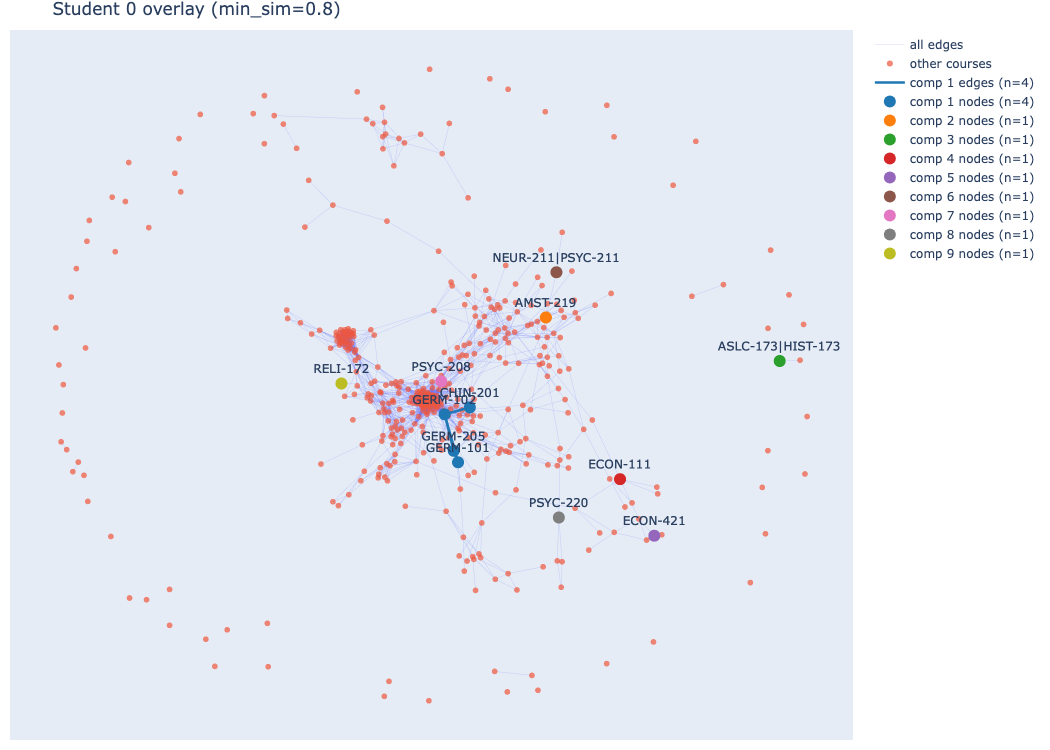

In [70]:
plot_student_interactive(0, min_sim=0.8)

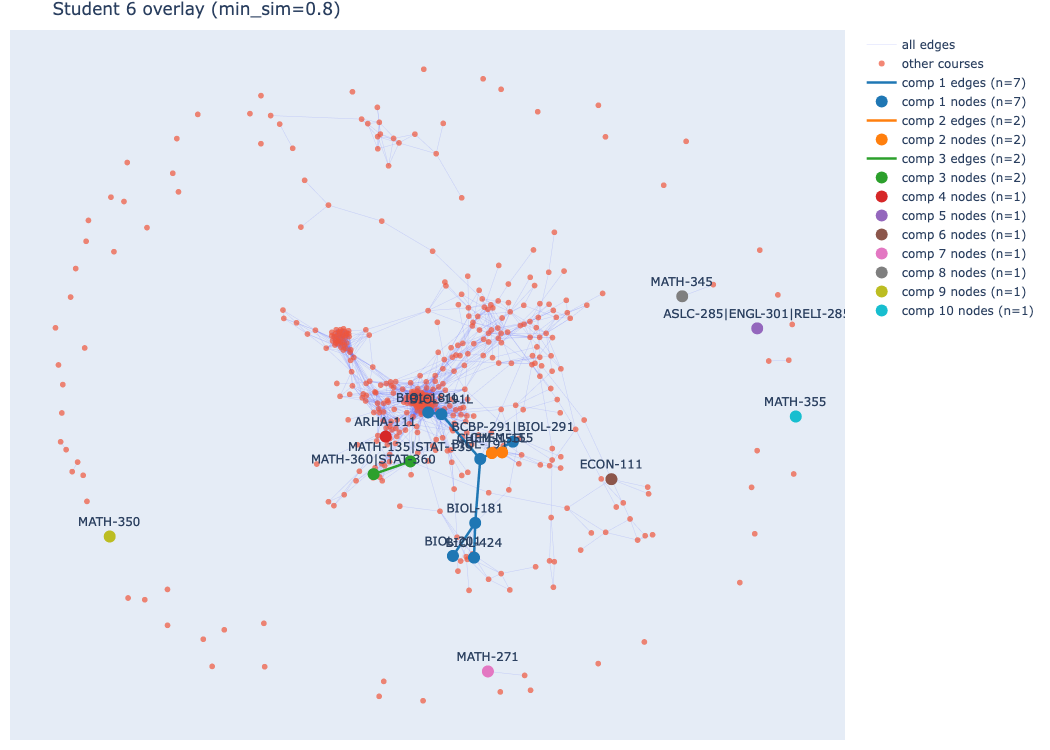

In [46]:
plot_student_interactive(6, min_sim=0.8)